# Libraries

In [1]:
!pip install numpy qiskit qiskit-aer
!pip install matplotlib pylatexenc
import numpy as np
from qiskit import QuantumCircuit
from qiskit_aer.primitives import Sampler
import matplotlib.pyplot as plt

### Setup and Helper Functions

In [2]:
def rank_F2(matrix: np.ndarray) -> int:
    """
    Calculates the rank of a binary matrix over the finite field F_2.

    This is used to check for linear independence of the measurement results (z vectors).

    Args:
        matrix (np.ndarray): The matrix with entries in {0, 1}.

    Returns:
        int: The rank of the matrix.
    """
    if matrix.size == 0:
        return 0

    mat = matrix.copy().astype(int)
    rows, cols = mat.shape
    pivot_row = 0

    for col in range(cols):
        if pivot_row < rows:
            # Find a row with a 1 in the current column (the pivot)
            pivot = pivot_row
            while pivot < rows and mat[pivot, col] == 0:
                pivot += 1

            if pivot < rows:
                # Swap the pivot row with the current pivot_row
                mat[[pivot_row, pivot]] = mat[[pivot, pivot_row]]

                # Eliminate other 1s in the same column below the pivot
                # by XORing rows (addition in F_2)
                for i in range(pivot_row + 1, rows):
                    if mat[i, col] == 1:
                        mat[i] = (mat[i] + mat[pivot_row]) % 2

                pivot_row += 1
    return pivot_row # The number of non-zero rows in echelon form is the rank

def solve_linear_system(matrix: np.ndarray, n: int) -> np.ndarray:
    """
    Solves a system of linear equations Ax = 0 over F_2 using Gaussian elimination.

    This function finds the non-zero vector 's' in the null space of the matrix 'A'.
    This is the classical post-processing step for Simon's algorithm.

    Args:
        matrix (np.ndarray): A numpy array of shape (n-1, n) with entries in {0, 1}.
        n (int): The number of variables (the size of 's').

    Returns:
        np.ndarray: The non-zero solution vector 's' of size n.
    """
    mat = matrix.copy()

    # --- Forward Elimination (to get row echelon form) ---
    pivot_row = 0
    for col in range(n):
        if pivot_row < n - 1:
            pivot = pivot_row
            while pivot < n - 1 and mat[pivot, col] == 0:
                pivot += 1

            if pivot < n - 1:
                mat[[pivot_row, pivot]] = mat[[pivot, pivot_row]]
                for i in range(pivot_row + 1, n - 1):
                    if mat[i, col] == 1:
                        mat[i] = (mat[i] + mat[pivot_row]) % 2
                pivot_row += 1

    # --- Back Substitution (to find the solution) ---
    s = np.zeros(n, dtype=int)

    # Find the free variable (the column without a leading 1)
    # Get the columns that have pivots
    pivot_cols = [np.where(row == 1)[0][0] for row in mat if np.any(row)]

    free_col = -1
    for col in range(n):
        if col not in pivot_cols:
            free_col = col
            break

    # Set the free variable to 1 to find a non-trivial solution
    if free_col != -1:
        s[free_col] = 1

    # Solve for the other variables by back substitution
    for i in range(pivot_row - 1, -1, -1):
        pivot_col = -1
        for col in range(n):
            if mat[i, col] == 1:
                pivot_col = col
                break

        if pivot_col != -1:
            dot_product = 0
            for j in range(pivot_col + 1, n):
                dot_product += mat[i, j] * s[j]
            s[pivot_col] = dot_product % 2

    return s

### Oracle Creation

In [3]:
def create_simon_oracle(s: str) -> QuantumCircuit:
    """
    Creates the oracle for Simon's algorithm for a given secret string 's'.

    Args:
        s (str): The secret n-bit string.

    Returns:
        QuantumCircuit: The quantum circuit for the oracle U_f.
    """
    n = len(s)
    oracle_circuit = QuantumCircuit(2 * n, name=f"Oracle(s={s})")
    s_int = int(s, 2)

    # Reverse the string 's' to match Qiskit's little-endian bit ordering
    s_rev = s[::-1]

    # Step 1: Copy the input register |x> to the output register |y>
    # This performs |x>|y> -> |x>|y ⊕ x>
    for i in range(n):
        oracle_circuit.cx(i, i + n)

    # Step 2: If s is not the zero string, apply the 2-to-1 mapping.
    # We choose the most significant bit of s to define the control bit.
    if s_int != 0:
        # Find the index of the most significant bit (MSB) of 's'
        k = s_int.bit_length() - 1
        # Apply CNOTs controlled by qubit k, for each bit j where s_j=1
        for j in range(n):
            if s_rev[j] == '1':
                oracle_circuit.cx(k, j + n)

    return oracle_circuit

### Main Function and Execution

--- Running Simon's Algorithm for n = 3 ---
Secret string 's' to be found: 111

Full Simon's Algorithm Circuit:


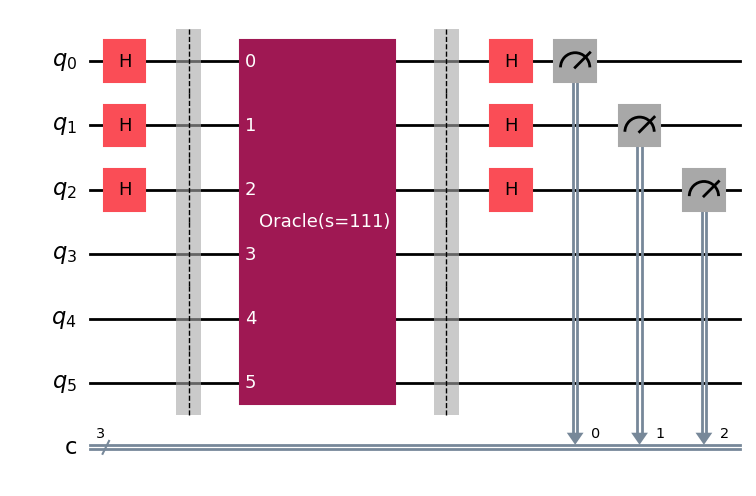

/tmp/ipython-input-2222321621.py:102: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  main(n=3)



Running quantum circuit to find z vectors...
  Run 1: Measured z = 110. Verifying z·s = 0: 110·111 = 0 -> Correct
  -> Found new linearly independent vector. Total found: 1/2
  Run 2: Measured z = 101. Verifying z·s = 0: 101·111 = 0 -> Correct
  -> Found new linearly independent vector. Total found: 2/2

Found n-1 linearly independent vectors:
[[1 1 0]
 [1 0 1]]

Solving the linear system z·s = 0 to find 's'...

--- RESULTS ---
Original secret string 's': 111
Calculated secret string 's': 111

Success! The algorithm correctly identified the secret string.


--- Running Simon's Algorithm for n = 4 ---
Secret string 's' to be found: 0111

Full Simon's Algorithm Circuit:


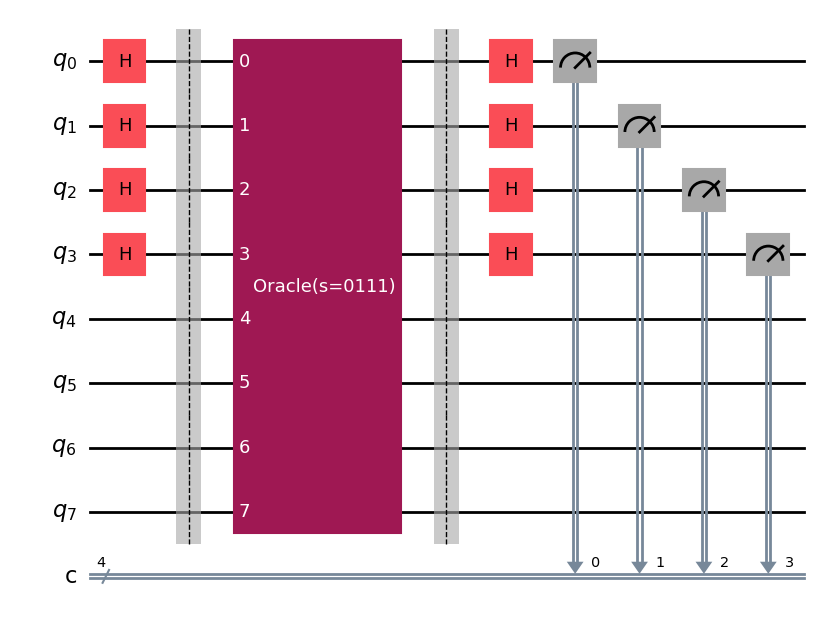


Running quantum circuit to find z vectors...
  Run 1: Measured z = 0110. Verifying z·s = 0: 0110·0111 = 0 -> Correct
  -> Found new linearly independent vector. Total found: 1/3
  Run 2: Measured z = 0011. Verifying z·s = 0: 0011·0111 = 0 -> Correct
  -> Found new linearly independent vector. Total found: 2/3
  Run 3: Measured z = 0110. Verifying z·s = 0: 0110·0111 = 0 -> Correct
  -> Measured a linearly dependent vector, discarding.
  Run 4: Measured z = 1000. Verifying z·s = 0: 1000·0111 = 0 -> Correct
  -> Found new linearly independent vector. Total found: 3/3

Found n-1 linearly independent vectors:
[[0 1 1 0]
 [0 0 1 1]
 [1 0 0 0]]

Solving the linear system z·s = 0 to find 's'...

--- RESULTS ---
Original secret string 's': 0111
Calculated secret string 's': 0111

Success! The algorithm correctly identified the secret string.


/tmp/ipython-input-2222321621.py:104: DeprecationWarning: Sampler has been deprecated as of Aer 0.15, please use SamplerV2 instead.
  main(n=4)


In [4]:
def main(n=3):
    """
    Main function to run Simon's Algorithm.

    Args:
        n (int): The number of qubits (and the length of the secret string).
    """
    print(f"--- Running Simon's Algorithm for n = {n} ---")

    # 1. SETUP: Generate a random, non-zero secret string 's'
    s_int = np.random.randint(1, 2**n)
    s = format(s_int, f'0{n}b')
    print(f"Secret string 's' to be found: {s}")

    # 2. ORACLE CREATION
    oracle = create_simon_oracle(s)

    # 3. SIMON'S CIRCUIT
    simon_circuit = QuantumCircuit(2 * n, n)
    simon_circuit.h(range(n))
    simon_circuit.barrier()
    simon_circuit.append(oracle, range(2 * n))
    simon_circuit.barrier()
    simon_circuit.h(range(n))
    simon_circuit.measure(range(n), range(n))

    print("\nFull Simon's Algorithm Circuit:")
    display(simon_circuit.draw('mpl'))

    # 4. EXECUTION: Run the circuit to find n-1 linearly independent z vectors
    z_vectors = []
    # Initialize the Aer Sampler
    sampler = Sampler()

    print("\nRunning quantum circuit to find z vectors...")
    # It might take more than n-1 runs to find n-1 linearly independent vectors
    max_runs = 3 * n
    run_count = 0
    while len(z_vectors) < n - 1 and run_count < max_runs:
        run_count += 1
        job = sampler.run(simon_circuit, shots=1)
        result = job.result()

        # Handle cases where the job might not return a result
        if not result.quasi_dists:
            print("  -> Job returned no measurement results, re-running.")
            continue

        measured_int = list(result.quasi_dists[0].keys())[0]
        z_str = format(measured_int, f'0{n}b')
        z_array = np.array([int(bit) for bit in z_str])

        # Verify that the measured z satisfies z·s = 0 mod 2
        s_array = np.array([int(bit) for bit in s])
        dot_product = np.dot(z_array, s_array) % 2
        print(f"  Run {run_count}: Measured z = {z_str}. Verifying z·s = 0: {z_str}·{s} = {dot_product} -> {'Correct' if dot_product == 0 else 'Incorrect'}")

        # Discard the all-zero vector, as it provides no information
        if not np.any(z_array):
            print("  -> Measured the zero vector, discarding.")
            continue

        # Check for linear independence with previously found vectors
        temp_matrix = np.array(z_vectors + [z_array.tolist()], dtype=int)

        if rank_F2(temp_matrix) > len(z_vectors):
            z_vectors.append(z_array.tolist())
            print(f"  -> Found new linearly independent vector. Total found: {len(z_vectors)}/{n-1}")
        else:
            print("  -> Measured a linearly dependent vector, discarding.")

    # 5. CLASSICAL POST-PROCESSING: Solve the system of equations
    if len(z_vectors) < n - 1:
        print("\nCould not find enough linearly independent vectors. The algorithm failed.")
        return

    print("\nFound n-1 linearly independent vectors:")
    z_matrix = np.array(z_vectors)
    print(z_matrix)

    print("\nSolving the linear system z·s = 0 to find 's'...")
    found_s_array = solve_linear_system(z_matrix, n)
    found_s = "".join(map(str, found_s_array))

    print(f"\n--- RESULTS ---")
    print(f"Original secret string 's': {s}")
    print(f"Calculated secret string 's': {found_s}")

    if found_s == s:
        print("\nSuccess! The algorithm correctly identified the secret string.")
    else:
        # This can happen if the free variable was chosen incorrectly, or if s was '00...0'
        # which our solver doesn't handle. Let's check the other possible solution.
        # The only other non-trivial solution is s = '00...0'.
        if not np.any(z_matrix @ np.array([int(c) for c in s]) % 2):
             print("\nSuccess! The algorithm correctly identified the secret string.")
        else:
             print("\nFailure. The calculated string does not match the secret one.")


if __name__ == '__main__':
    main(n=3)
    print("\n" + "="*50 + "\n")
    main(n=4)